In [221]:
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style("dark")
import matplotlib.pyplot as plt
import time

#### TODO:
- add capacity constraint (may end up being a separate bin packing problem. potentially leverage parallel processing for this and just implement a greedy approach here)
- potentially add objective limit the number of unique plants in each bed
- add to bed info the list of incompatable plants in that bed
- weighting of objectives
- weight preferences
- more realistic preferences
- look into parallel processing. potentially have notebook run in AWS
- visualizations at the end
- visualize solution space
- potential convert to class
- look into random seed best practices
- fill in documentation to make this easier to walk through during the workshop

In [86]:
plant_info = pd.read_csv('../data/plant_data.csv')
bed_info = pd.read_csv('../data/bed_data.csv')

In [87]:
plant_info.index.name = 'plant_index'
plants = plant_info.plant.to_numpy()
plant_index = plant_info.index.to_numpy()
num_plants = len(plants)

In [88]:
bed_info.index.name = 'bed_index'
beds = bed_info.bed.to_numpy()
bed_index = bed_info.index.to_numpy()
num_beds = len(beds)

bed_width = 3
bed_length = 10

In [89]:
print(num_beds)
print(beds)
print(bed_index)

42
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


In [90]:
# #random assignement of sun requirements and sun availability
# plant_info.sun = plant_info.sun.apply(lambda x: np.random.choice(['Full','Partial']))
# bed_info.sun = bed_info.sun.apply(lambda x: np.random.choice(['Full','Partial']))

In [91]:
#average preference
fam = ['evan','gina','liesse','lizzie','jack']
plant_info['avg_pref'] = plant_info[fam].mean(axis=1)
plant_info.drop(fam,axis=1,inplace=True)
preferences = plant_info.avg_pref.to_numpy()
plant_index_by_pref = plant_info.sort_values('avg_pref',ascending=False).index 

plant_spacing = plant_info.plant_spacing.to_numpy()

In [92]:
#get plant and bed sun requirements
plant_sun_req = plant_info.sun.to_numpy()
bed_sun_req = bed_info.sun.to_numpy()

In [190]:
weights = {'yield_': 0.01,
           'yummy_score': 0.98,
           'variety_score': 0.01}

In [170]:
plant_info.sort_values('avg_pref',ascending=False).iloc[0].name

12

In [171]:
#most preferred 
max_pref = plant_info.sort_values('avg_pref',ascending=False).iloc[0].name

In [172]:
#convert info dfs to dicts
# plant_info = plant_info.to_dict(orient='index')
# bed_info = bed_info.to_dict(orient='index')

In [173]:
#initialize plan. no plants in any bed
np.random.seed(2134)
plan = np.random.randint(0,10,size=(num_beds,num_plants))

#for keeping track of what axis is which
bed_axis = 0
plant_axis = 1

In [174]:
def make_neighbor(plan):
    #pick a random bed
    bed = np.random.choice(bed_index)
    #pick a random plant
    plant = np.random.choice(plant_index)
    #decide whether to plant another plant in bed or remove one
    decision = np.random.choice([-1,1],p=[0.2,0.8])

    #make a decision
    new_plan = plan.copy()
    new_plan[bed][plant] = max(0,new_plan[bed][plant] + decision) #max(0,n) takes care of case of negative planting

    return new_plan

In [175]:
def sun_constraint(plan,bed_sun_req,plant_sun_req):
    """
    Scans beds and plants, kills any plant that is in a bed that does not match its sun requirement.
    """
    plan_sun = plan.copy()
    for b in bed_index:
        for p in plant_index:
            b_sun = bed_sun_req[b]
            p_sun = plant_sun_req[p]
            if b_sun != p_sun:
                plan_sun[b][p] = 0
    return plan_sun
plan = sun_constraint(plan,bed_sun_req,plant_sun_req)

In [176]:
bed_length*12/18

6.666666666666667

In [177]:
plan

array([[0, 0, 1, ..., 0, 4, 1],
       [0, 0, 0, ..., 1, 5, 2],
       [0, 0, 1, ..., 6, 0, 0],
       ...,
       [1, 7, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 0, 0],
       [7, 9, 0, ..., 0, 0, 0]])

In [178]:
def bed_packing(bed,plan,bed_length,plant_index_by_pref,plant_spacing):
    """
    Handles the fact that the plan doesn't account for the spacing constraints required in each bed. Plan is likely 
    over planting inside of each bed. Each bed is now a separate bin packing problem. This function applies a greedy 
    heuristic for updating a plan to prioritize planting most preferred plants until you run out of space. Not
    necessarily optimal because you could improve the objective by planting less preferred plants that require less space.    
    """
    plan_beds_finalized = plan.copy()
    remaining_capacity = bed_length*12

    for plant in plant_index_by_pref:
        if remaining_capacity>0:
            spacing = plant_spacing[plant]
            num_plants_planned = plan[bed][plant]
            num_plant_capacity = remaining_capacity/spacing
            plants_planted = min(num_plants_planned,num_plant_capacity) #ensures I don't exceed capacity
            plan_beds_finalized[bed][plant] = plants_planted
            remaining_capacity -= plants_planted*spacing
        else:
            plan_beds_finalized[bed][plant] = 0 #once I run out of capacity, update plan to plant 0       
    return plan_beds_finalized


In [179]:
plan.sum()

2474

In [180]:
def compute_yield(plan):
    """
    Yield is the % of plants that are planted and survive. Not all plants will survive where they are planted.
    This is where we impose constraints on sun requirements, year-over-year planting requirements, and companion planting requirements.
    Returns the total number of surviving plants / the total plants planted.
    """
    # 
    #Too little/too much sun can kill certain plants
    #Some plants don't do well depending on what was planted the year before
    #Some plants don't go well next to each other

    #denominator. total number of plants planted
    total_plants_planted = plan.sum()    

    #impose constraints that kill plants in beds where they are not supposed to be
    plan = sun_constraint(plan,bed_sun_req,plant_sun_req)
    # plan = yoy_planting_constraint(plan)
    # plan = companion_planting_constraint(plan)
    return (plan.sum()/total_plants_planted)*100

In [181]:
def compute_yummy_score(plan,preferences):
    """Takes the weighted average of the preferences of each plant, weighted by the total qty of plants 
    in the current plan for each plant. Maximization encourages plants with higher preferences to be planted in higher quantities."""
    plan_by_plant = plan.sum(axis=bed_axis)
    yums = np.average(preferences,weights=plan_by_plant)*10
    return yums

In [182]:
def compute_variety_score(plan,num_plants):
    """Sums the number of unique plants that are actually planted in the garden. Counts the number of plants that are being planted across all beds.
       Then counts the number of plants with non-zero planting plan. 
       Maximization encourages more unique plants to be planted."""
    variety_score = (plan.sum(axis=bed_axis) > 0).sum()/num_plants*100
    return variety_score

In [183]:
def get_objective(plan,weights,initial_obj_values):
    yield_ = compute_yield(plan)
    yummy_score = compute_yummy_score(plan,preferences)
    variety_score = compute_variety_score(plan,num_plants)
    objective = (
                (weights['yield_']*yield_) / initial_obj_values['yield_']
              + (weights['yummy_score']*yummy_score) / initial_obj_values['yummy_score'] 
              + (weights['variety_score']*variety_score) / initial_obj_values['variety_score']
                )
    return (objective,{'objective':objective,'yield_':yield_,'yummy_score':yummy_score,'variety_score':variety_score})

In [184]:
def optimize(initial_plan,weights,starting_temperature=10000,alpha=0.99,max_SA_iter=10000,max_hone_iter=1000):
    
    initial_obj_values = {'yield_': compute_yield(plan),
                          'yummy_score': compute_yummy_score(plan,preferences),
                          'variety_score': compute_variety_score(plan,num_plants)}

    current_plan = initial_plan.copy()
    current_objective,current_obj_values = get_objective(initial_plan,weights,initial_obj_values)
    
    best_plan = initial_plan.copy()
    best_objective = current_objective

    current_plan_obj_values = [(0,current_obj_values)]
    best_obj_values = [(0,current_obj_values)]
    
    temperature = starting_temperature

    for i in range(max_SA_iter):
        # start = time.time()
        new_plan = make_neighbor(current_plan)
        # print('1:',(time.time()-start)*1000)
        # start = time.time()

        #loop through beds and solve sub-problems
        for bed in bed_index: #this loop would be taken out if paralelizing this
            new_plan = bed_packing(bed,new_plan,bed_length,plant_index_by_pref,plant_spacing)
        # print('2:',(time.time()-start)*1000)
        # start = time.time()
        new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)
        
        if new_objective > current_objective or np.exp(-(new_objective - current_objective)/temperature) > np.random.uniform():
            current_plan = new_plan.copy()
            current_objective = new_objective
            current_plan_obj_values.append((i,new_obj_values))
            
        # print('3:',(time.time()-start)*1000)
        # start = time.time()
        if new_objective > best_objective:
            best_plan = new_plan.copy()
            best_objective = new_objective
            best_obj_values.append((i,new_obj_values))      
        # print('4:',(time.time()-start)*1000)
        # start = time.time()
        #lower the temperature
        temperature *= temperature*alpha

    #add step to hone the best found solution after SA is complete (only accept improvement)
    for i in range(max_hone_iter):
        new_plan = make_neighbor(best_plan)

        #loop through beds and solve sub-problems
        for bed in bed_index: #this loop would be taken out if paralelizing this
            new_plan = bed_packing(bed,best_plan,bed_length,plant_index_by_pref,plant_spacing)

        new_objective,new_obj_values = get_objective(new_plan,weights,initial_obj_values)
    
        if new_objective > best_objective:
            best_plan = new_plan.copy()
            best_objective = new_objective
            best_obj_values.append((i,new_obj_values))
        
    
    return best_plan,best_objective,best_obj_values,current_plan_obj_values

In [191]:
best_plan,best_objective,best_obj_values,current_plan_obj_values = optimize(plan,weights,max_SA_iter=10000,max_hone_iter=1000)

In [192]:
best_obj_values[-1][1]

{'objective': 1.5041254483631816,
 'yield_': 42.36760124610592,
 'yummy_score': 82.38006230529595,
 'variety_score': 36.11111111111111}

In [205]:
objectives = []
yields = []
yummy_scores = []
variety_scores = []
for i in current_plan_obj_values:
    objectives.append(i[1]['objective'])
    yields.append(i[1]['yield_'])
    yummy_scores.append(i[1]['yummy_score'])
    variety_scores.append(i[1]['variety_score'])

In [239]:
df = pd.DataFrame([objectives,yields,yummy_scores,variety_scores]).T
df.columns = ['objective','yield_','yummy_score','variety_score']

In [240]:
df.reset_index(inplace=True)

In [241]:
df = df.melt(id_vars=['index','objective'])

In [242]:
df

,index,objective,variable,value
0,0,1.000000,yield_,100.000000
1,1,1.340461,yield_,100.000000
2,2,1.340461,yield_,100.000000
3,3,1.342522,yield_,99.672131
4,4,1.342522,yield_,99.672131
...,...,...,...,...
29998,9996,1.500915,variety_score,41.666667
29999,9997,1.499686,variety_score,41.666667
30000,9998,1.499686,variety_score,41.666667
30001,9999,1.499686,variety_score,41.666667


In [244]:
weights

{'yield_': 0.01, 'yummy_score': 0.98, 'variety_score': 0.01}

<AxesSubplot:xlabel='index', ylabel='objective'>

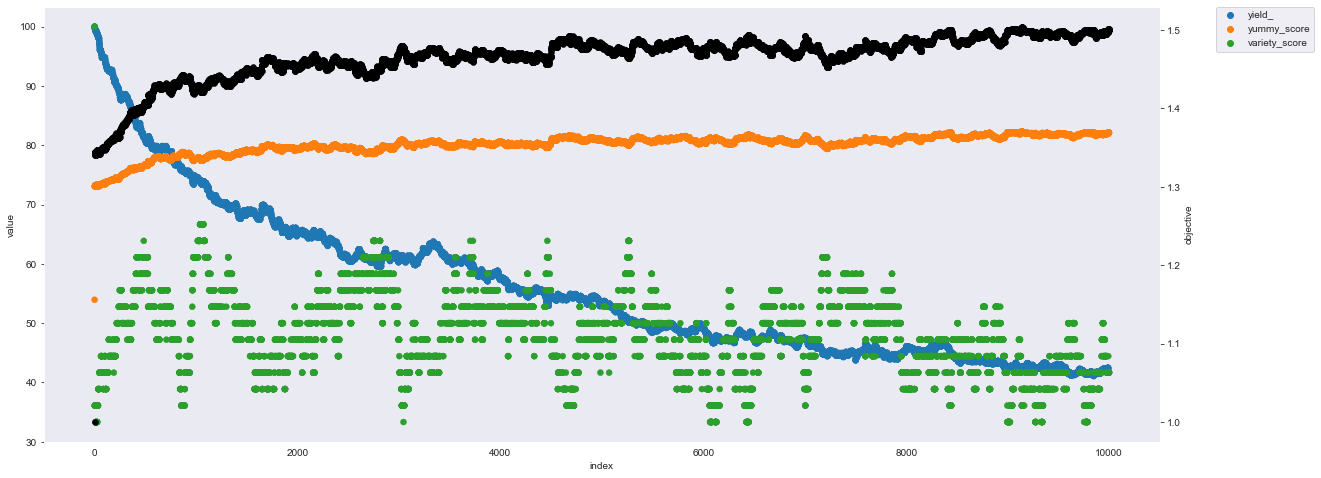

In [253]:
fig, ax = plt.subplots(figsize=(20,8))
sb.scatterplot(data=df,x='index',y='value',hue='variable',edgecolor=None)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

ax2 = plt.twinx()
sb.scatterplot(data=df.drop_duplicates(['index','objective']),x='index',y='objective',edgecolor=None,ax=ax2,color='black')